<a href="https://colab.research.google.com/github/leo-alves-melo/busPredictor/blob/master/dumpBusPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating a dump algorithm for bus prediction given the location of the vehicle

In [3]:
# Install dependencies
!pip install arrow

In [0]:
# Importing packages

from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import pprint
import json
import pandas as pd
import numpy as np
import arrow
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from functools import reduce
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
from datetime import timedelta
import copy
from google.colab import files
from google.colab import drive
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
%matplotlib inline

In [0]:
# Setting variables

data_location = '/content/gdrive/My Drive/Unicamp/11 semestre/TCC - Leonardo Alves de Melo/Colab/Data/data.csv'

base_api = 'https://api.demo.konkerlabs.net'
username = "student_smartcampus@konkerlabs.com"
password = 'SdExnFiHcGrK'

circulino = "3b7c728c-cf13-45ca-a803-d94a598113d0"
circulino1 = "0b525e25-6962-4ee4-8f8a-834e3e33698d"
circulino2 = "8ab6ae21-9d9e-4637-8c56-60ba15691fd2"
circulino3 = "8f4ab4d2-203e-4043-b4b1-bffca39f8686"
circulino4 = "6ce968a1-a32b-4f8c-bc39-4463f50f4591"
circulino5 = "a028f083-8375-45ec-a42f-7e864fd5f8d7"
circulino6 = "eb0ec27f-16d0-4504-a331-af5b1e24eac6"
circulino7 = "826f5fe4-ec9b-4de7-87f8-93be40963612"
circulino8 = "8a33a2fe-8325-4c71-b937-8cc75b85bca4"

# These are the available circulars because the others do not have data
available_circulars = [circulino4, circulino5, circulino6, circulino7, circulino8]

# Coordinates of the home of the circular
latitude_home = -22.829636
longitude_home = -47.061038
home = {'geolocation':{'lat': latitude_home, 'lon': longitude_home}} 

time_formatter1 = '%Y-%m-%dT%H:%M:%S.%fZ'
time_formatter2 = '%Y-%m-%dT%H:%M:%SZ'

bus_stop_latitude = [-22.82961372593675,-22.827572007972478,-22.827839460784613,-22.82572604482161,-22.824259395268815,-22.824342054788538,-22.82339495615896,-22.823696505309023,-22.819732610271284,-22.818471307010142,-22.818031511340962,-22.818063107264045,-22.81897827715408,-22.81851763367064,-22.816911924943703,-22.8149687910257,-22.81348716556454,-22.812519511209437,-22.812994160952606,-22.81423669359395,-22.81654917375286,-22.819294695494193,-22.82167567621637,-22.825048660966733,-22.827383217435795,-22.82880780070171,-22.830572518710206,-22.82966004880576,-22.82961372593675,-22.827572007972478,-22.827839460784613,-22.82572604482161,-22.824234047789606,-22.822700953548658,-22.821469396127068,-22.819146975421376,-22.816566655760123,-22.81417771866976,-22.813895379025784,-22.813831568436914,-22.812777378217994,-22.81348716556454,-22.81504658684353,-22.81561825362484,-22.817031676329528,-22.819334903296923,-22.821000894424408,-22.821312063645497,-22.819994834014597,-22.817413656323698,-22.81471355050243,-22.81566370714975,-22.818063107264045,-22.81826851842413,-22.818182857637566,-22.81834806053481,-22.819694150746503,-22.823807510190303,-22.82486161502456,-22.827383217435795,-22.82880780070171,-22.830572518710206,-22.82966004880576,-22.82961372593675,-22.827572007972478,-22.827839460784613,-22.82572604482161,-22.824234047789606,-22.822700953548658,-22.821469396127068,-22.819146975421376,-22.816566655760123,-22.81417771866976,-22.813895379025784,-22.813831568436914,-22.812777378217994,-22.81348716556454,-22.81504658684353,-22.81561825362484,-22.817031676329528,-22.819334903296923,-22.821000894424408,-22.821312063645497,-22.819994834014597,-22.817413656323698,-22.81471355050243,-22.81466547432292,-22.81404623926024,-22.81348716556454,-22.81566370714975,-22.818063107264045,-22.81826851842413,-22.818182857637566,-22.81834806053481,-22.819694150746503,-22.823807510190303,-22.82486161502456,-22.827383217435795,-22.82880780070171,-22.830572518710206,-22.82966004880576,-22.82961372593675,-22.827572007972478,-22.827839460784613,-22.82572604482161,-22.824234047789606,-22.822700953548658,-22.821469396127068,-22.819146975421376,-22.816566655760123,-22.81417771866976,-22.813895379025784,-22.814990643788022,-22.817031676329528,-22.819334903296923,-22.821000894424408,-22.821312063645497,-22.819994834014597,-22.817413656323698,-22.81471355050243,-22.81566370714975,-22.818063107264045,-22.824468293279722,-22.82486161502456,-22.827383217435795,-22.82880780070171,-22.830572518710206,-22.82966004880576]
bus_stop_longitude = [-47.06137016415596,-47.06275820732117,-47.06677682697773,-47.06618271768093,-47.06345960497856,-47.059839963912964,-47.060167863965034,-47.061488181352615,-47.06003777682781,-47.05960728228092,-47.0604857057333,-47.06308342516422,-47.064886540174484,-47.06610158085823,-47.06609085202217,-47.06696391105652,-47.065243273973465,-47.06756003201008,-47.06950530409813,-47.07185357809061,-47.07285739481449,-47.07241617143154,-47.070336788892746,-47.067298516631126,-47.067575454711914,-47.066226303577366,-47.06210911273956,-47.06069424748421,-47.06137016415596,-47.06275820732117,-47.06677682697773,-47.06618271768093,-47.06772968173027,-47.06905469298363,-47.07022547721863,-47.07222707569599,-47.07261733710766,-47.071487456560135,-47.069668248295784,-47.06821247935295,-47.0677524805069,-47.065243273973465,-47.06436015665531,-47.06585146486759,-47.06623703241348,-47.06711947917938,-47.068121284246445,-47.067411839962006,-47.06532709300518,-47.063652724027634,-47.064024209976196,-47.06265024840826,-47.06308342516422,-47.063074707984924,-47.06050112843508,-47.05967500805855,-47.06013835966587,-47.06294797360897,-47.06547796726227,-47.067575454711914,-47.066226303577366,-47.06210911273956,-47.06069424748421,-47.06137016415596,-47.06275820732117,-47.06677682697773,-47.06618271768093,-47.06772968173027,-47.06905469298363,-47.07022547721863,-47.07222707569599,-47.07261733710766,-47.071487456560135,-47.069668248295784,-47.06821247935295,-47.0677524805069,-47.065243273973465,-47.06436015665531,-47.06585146486759,-47.06623703241348,-47.06711947917938,-47.068121284246445,-47.067411839962006,-47.06532709300518,-47.063652724027634,-47.064024209976196,-47.05708935856819,-47.05889314413065,-47.065243273973465,-47.06265024840826,-47.06308342516422,-47.063074707984924,-47.06050112843508,-47.05967500805855,-47.06013835966587,-47.06294797360897,-47.06547796726227,-47.067575454711914,-47.066226303577366,-47.06210911273956,-47.06069424748421,-47.06137016415596,-47.06275820732117,-47.06677682697773,-47.06618271768093,-47.06772968173027,-47.06905469298363,-47.07022547721863,-47.07222707569599,-47.07261733710766,-47.071487456560135,-47.069668248295784,-47.067154347896576,-47.06623703241348,-47.06711947917938,-47.068121284246445,-47.067411839962006,-47.06532709300518,-47.063652724027634,-47.064024209976196,-47.06265024840826,-47.06308342516422,-47.06490330398077,-47.06547796726227,-47.067575454711914,-47.066226303577366,-47.06210911273956,-47.06069424748421]

In [0]:
# Classes definitions

# Coordinate of a 
class Coordinate():
    def __init__(self, latitude, longitude, timestamp = None, id_line = None, guid = None):
        self.latitude = latitude
        self.longitude = longitude
        self.timestamp = timestamp
        self.id_line = id_line
        self.device_guid = guid
    
    def from_coordinate(coordinate):
        return Coordinate(coordinate.latitude, coordinate.longitude, coordinate.timestamp, coordinate.id_line, coordinate.device_guid)

home = Coordinate(latitude_home, longitude_home)

class Path():
    def __init__(self, coordinates, id_line):
        self.coordinates = coordinates
        self.id_line = id_line
        
class Predictor():
    def __init__(self, algorithm):
        self.algorithm = algorithm
        self.next_path()
        
    def train(self, X, y):
        self.algorithm.fit(np.array(X), np.array(y))
    
    def next_path(self):
        self.reset_path()
        
    def reset_path(self):
        self.path = []
    
    def iterate(self, coordinate):
        self.path.append(coordinate)
        return self.algorithm.predict(np.array(self.path))
    
class DumpAlgorithm():
    def fit(self, X, y):
        pass
    
    def predict(self, path):
        musium_hot_point = Coordinate(-22.814127, -47.058833)
        circular1_hot_point = Coordinate(-22.824493, -47.059594)
        fec_hot_point = Coordinate(-22.817975, -47.059667)

        if has_distance_from_coordinate(path, musium_hot_point, 0.3):
            return 4
        if has_distance_from_coordinate(path, circular1_hot_point, 0.25):
            return 1
        if has_distance_from_coordinate(path, fec_hot_point, 0.25):
            return 2

        return 3

# Bayes algorithm fits the model for 350 positions, 
# which means almost 1h oh bus travel
# Max size of all columns
max_column = 350
class BayesAlgorithm():
    def fit(self, X, y):

        train = []
        response = []
        
        for index_line in range(len(X)):
            for index_column in range(max_column):
                
                train_sample = X[index_line][0:index_column+1]
                train_sample = np.array(reduce(list.__add__, train_sample))
                appended = np.zeros(3*max_column - len(train_sample))
                
                train_sample = np.append(train_sample, appended)
                
                train.append(np.array(train_sample))
                response.append(y[index_line])
        
        train = np.array(train)
        response = np.array(response)
        
        self.model = GaussianNB().fit(pd.DataFrame(train), pd.DataFrame(response))
    
    def predict(self, path):
        
        train_sample = path.flatten()
        appended = np.zeros(3*max_column - len(train_sample))

        sample = np.append(np.array(path), appended)
        return self.model.predict(np.array(sample).reshape(1, -1))[0]
        

In [0]:
# Data Collector Functions

def get_data(guid):
    global oauth
    
    print('coletando: ' + guid)
    
    dt_start = arrow.utcnow().to('America/Sao_Paulo').floor('day')
    timestamp_init = datetime(2003, 9, 25, 0, 0).isoformat()
    channel = 'info'
    timestamp_final = arrow.utcnow().isoformat()
    application = 'default'
    df = pd.DataFrame()
    lastlen = 0
    while timestamp_init < timestamp_final:
        try:

            stats = oauth.get("https://api.demo.konkerlabs.net/v1/{}/incomingEvents?q=device:{} channel:{} timestamp:>{}&sort=oldest&limit=10000".format(application,guid, channel, timestamp_init)).json()['result']
            if (len(stats)<2) and (lastlen<20000):
                break
            timestamp_init = stats[-1]['timestamp']
            new_data = [{'timestamp' : json['timestamp'], 
                         'latitude': json['geolocation']['lat'], 
                         'longitude': json['geolocation']['lon'],
                         'id_line': json['payload']['id_linha']} for json in stats]

            df = df.append(pd.io.json.json_normalize(new_data))
            
            lastlen = len(stats)
        except:
            pass
    return df

def read_all_circular_data_from_server():
    # Authenticating

    client = BackendApplicationClient(client_id=username)
    oauth = OAuth2Session(client=client)
    token = oauth.fetch_token(token_url='{}/v1/oauth/token'.format(base_api),client_id=username,client_secret=password)
    
    # Reading all circular data

    df = pd.DataFrame(columns=['timestamp', 'geolocation'])
    for circular in available_circulars:
        new_df = get_data(circular)
        df = pd.concat([df, new_df])
        
    return df

def download_data(data):
    with open('data.json', 'w') as file:
        file.write(json.dumps(data))

    files.download('data.json')
    
def save_data_to_drive(df):
    drive.mount('/content/gdrive', force_remount=False)
    df.to_csv(data_location)

def load_data_from_drive():
    drive.mount('/content/gdrive', force_remount=False)
    dateparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
    return pd.read_csv(data_location, date_parser=dateparser)

In [0]:
# Data Filter Functions

# Calculates the distance in km
def distance_between(position1, position2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(position1.latitude)
    lon1 = radians(position1.longitude)
    lat2 = radians(position2.latitude)
    lon2 = radians(position2.longitude)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    
    return distance

# Calculates the distance in km
def distance_between_literal(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    
    return distance

def collect_time(timestamp):
    
    if isinstance(timestamp, str):
        try:
            return datetime.strptime(timestamp, time_formatter1)
        except:
            return datetime.strptime(timestamp, time_formatter2)
    elif isinstance(timestamp, pd.Series):
        return timestamp[0]
    else:
        return timestamp

# Calculates the velocity in km/h
def velocity_between(position1, position2):
    
    distance = distance_between(position1, position2)
    
    time1 = collect_time(position1.timestamp)
        
    time2 = collect_time(position2.timestamp)
    
    time_delta = (time2 - time1).total_seconds()/3600
    
    if time_delta == 0:
        return 0

    return distance/time_delta

def has_distance_from_home(path_df, distance = 1):
    return (path_df.apply(lambda row: distance_between(Coordinate(row['latitude'], row['longitude']), home) < distance, axis=1) == True).any()

def has_distance_greater_from_home(path_df, distance = 1):
    return (path_df.apply(lambda row: distance_between(Coordinate(row['latitude'], row['longitude']), home) > distance, axis=1) == True).any()

def has_distance_from_coordinate(path, coordinate, distance = 1):

    return any(distance_between_literal(position[1], position[2], coordinate.latitude, coordinate.longitude) < distance for position in path)

def parse_coordinate(json):
    try:
        return Coordinate(json['geolocation']['lat'], 
                          json['geolocation']['lon'], 
                          json['timestamp'], 
                          json['payload']['id_linha'], 
                          json['incoming']['deviceGuid'])
    except:
        return Coordinate(json['geolocation']['lat'], 
                          json['geolocation']['lon'])

# Append the next coordenate if it is valid. Returns false when the path ended
def validate_and_append_next_coordinate(row, path_df, has_distance_from_greater_from_home): 
    
    coordinate = Coordinate(row['latitude'], row['longitude'], row['date'], row['id_line'])
    
    # Checks if it is the first coordinate of the path
    if len(path_df.index) == 0:
        
        # Check if is close to the home, and if is, append the coordinate
        if distance_between(coordinate, home) < 0.1:
            return True, pd.DataFrame().append(row), has_distance_from_greater_from_home
        else:
            return True, pd.DataFrame(), has_distance_from_greater_from_home
        
    last_row = path_df.tail(1)
    last_coordinate = Coordinate(last_row['latitude'].iloc[0], last_row['longitude'].iloc[0], last_row['date'].iloc[0], last_row['id_line'].iloc[0])
    
    # Check if is duplicated
    if coordinate == last_coordinate:
        return True, path_df, has_distance_from_greater_from_home
    
    # Checks if the velocity of the next coordinate is too big or greater than zero
    if velocity_between(coordinate, last_coordinate) > 100 and velocity_between(coordinate, last_coordinate) > 0:
        return True, path_df, has_distance_from_greater_from_home
    
    # Checks the time difference

    time1 = last_coordinate.timestamp
    time2 = coordinate.timestamp
      
    if (time2 - time1).total_seconds() > 5*60:
        return False, path_df, has_distance_from_greater_from_home
    
    # Checks the id
    if coordinate.id_line != last_coordinate.id_line:
        return False, path_df, has_distance_from_greater_from_home
    
    # Check if the path have at least one coordinate far away from the home, so that the path started
    if has_distance_from_greater_from_home:
        # If we are close to home
        if distance_between(coordinate, home) < 0.1:
            new_df = path_df.append(row)
            return False, new_df, has_distance_from_greater_from_home
        else:
            return True, path_df.append(row), has_distance_from_greater_from_home
    else:
        if distance_between(coordinate, home) > 1:
            return True, path_df.append(row), True
        else:
            return True, path_df.append(row), False
    
def create_paths(df):
    paths_df = pd.DataFrame()
    current_path_df = pd.DataFrame()
    path_index = 0
    count_int = 0
    total = len(df.index)
    print('iniciando...')
    has_distance_from_greater_from_home = False
    for index, row in df.head(30000).iterrows():
        
        if 100*index/30000 > count_int + 1:
            count_int += 1
            print(str(count_int) + "% - " + str(len(paths_df.index)), end=' - ')
            
            
        still_appending, current_path_df, has_distance_from_greater_from_home = validate_and_append_next_coordinate(row, current_path_df, has_distance_from_greater_from_home)
        if not still_appending:
            
            # If there is few values on the path, we can discart it
            if len(current_path_df.index) < 100:
                current_path_df = pd.DataFrame()
                
            else:
                
                if has_distance_from_greater_from_home:
                    
                    path_index += 1
                    # Add a column with the index of the path to the df
                    current_path_df['Path Index'] = path_index
                    # Add the new path to the dataframe of paths
                    paths_df = paths_df.append(current_path_df)
                    current_path_df = pd.DataFrame()
                    
                else:
                    current_path_df = pd.DataFrame()
            
            has_distance_from_greater_from_home = False

                        
    return paths_df

In [0]:
# Data Visualization

def plot_path(path_df):

    latitudes = path_df.latitude
    longitudes = path_df.longitude
    
    numberOfDots = len(path_df.index)
    colors = cm.rainbow(np.linspace(0, 1, numberOfDots))
    
    plt.margins(0) # Fit the map in the image
    
    plt.scatter(longitudes, latitudes, color=colors)
    
    plt.scatter(bus_stop_longitude, bus_stop_latitude, marker='*')
        
    plt.show()

def plot_correctness(correctness):
    plt.plot(range(len(correctness)), correctness)
    plt.ylabel('Porcentagem')
    plt.xlabel('# Leituras')
    plt.title('Porcentagem de acerto por # de leituras')
    plt.grid(True)
    plt.show()

In [0]:
# Data Processing Functions

def average_window(window):
    
    return window.mean()
    
def apply_average_window_on_path(path, window_size = 10, window_shift = 2):
    index = 0
    new_path = []
    while index < len(path):
        window = path[index:index + window_size]
        new_coordinate = average_window(window)
        new_path.append(new_coordinate)
        index += window_shift
        
    return new_path

def apply_average_time_window(path_df, window_time = 10, window_time_shift = 2):
    index = 0
    new_path_df = pd.DataFrame()
    initial_time = path_df.date.min()
    
    while index < len(path_df.index):
        
        window = pd.DataFrame()
        while index < len(path_df.index) and path_df.date.iloc[index] < initial_time + timedelta(seconds=window_time):
            window = window.append(path_df.iloc[index])
            index += 1
            
        initial_time += timedelta(seconds=window_time)
        
        if len(window.index) > 0:
            average = average_window(window)
            
            new_path_df = new_path_df.append(average, ignore_index=True)
        
    return new_path_df

def separate_X_coordinate(coordinate, first_time):
    current_time = collect_time(coordinate.timestamp)
    difference_time = (current_time - first_time).total_seconds() 
    return [difference_time, coordinate.latitude, coordinate.longitude]

def separate_Y_id_line(path):
    return path[0].id_line

def separate_X_paths(paths):
    X = []
    for path in paths:
        first_time = collect_time(path[0].timestamp)
        X.append(list(map(lambda coordinate: separate_X_coordinate(coordinate, first_time), path)))
        
    return X

def separate_Y_paths(paths):
    Y = []
    for path in paths:
        Y.append(separate_Y_id_line(path))
        
    return Y     

def separate_train_test(paths):
    all_X = separate_X_paths(paths) 
    all_y = separate_Y_paths(paths)
    
    X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, random_state=1, test_size=0.2, stratify=all_y)
    
    return X_train, X_test, y_train, y_test

In [0]:
# Algorithm Functions
def predict_X(X, predictor):
    predicteds = []
    
    for path in X:

        predicted = []
        
        predictor.next_path()
        for coordinate in path:
            predicted.append(predictor.iterate(coordinate))
        
        predicteds.append(predicted)
    
    return predicteds

def predict(paths, predictor):
    #X_train, X_test, y_train, y_test = separate_train_test(paths)
    
    X = separate_X_paths(paths) 
    y = separate_Y_paths(paths)
    
    prediction_paths = []
    #predictor = Predictor(algorithm)
    #predictor.train(X_train, y_train)
    for path in X:

        prediction_path = []
        
        predictor.next_path()
        for coordinate in path:
            prediction_path.append(predictor.iterate(coordinate))
        
        prediction_paths.append(prediction_path)
    
    return prediction_paths, y

def anilyze_prediction(prediction, y):
    # Parses every value of the prediction to a boolean matching the correct response of y
    correctness = []
    max_column = 0
    for index in range(len(y)):
        correctness.append([])
        current_column = 0
        for predict in prediction[index]:
            correctness[index].append(predict == y[index])
            current_column += 1
            if current_column > max_column:
                max_column = current_column

    # Sum the correctness of every column to analyze the correctness per value readed
    correct_number_column = []
    for column in range(max_column):
        correct_number = 0
        number_of_read = 0
        for line in range(len(correctness)):
            
            try: 
                
                if correctness[line][column]:
                    correct_number += 1
                number_of_read += 1
            except:
                pass
        
        correct_number_column.append(correct_number*100 / number_of_read)
    return correct_number_column

In [47]:
df = load_data_from_drive()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df = df.drop(columns=['Unnamed: 0'])

In [0]:
df['date'] = pd.to_datetime(df['date'])

In [0]:
df

In [76]:
paths_df = create_paths(df)

iniciando...
1% - 0 - 2% - 448 - 3% - 448 - 4% - 996 - 5% - 996 - 6% - 1440 - 7% - 1440 - 8% - 1440 - 9% - 2344 - 10% - 2344 - 11% - 3020 - 12% - 3020 - 13% - 3386 - 14% - 3386 - 15% - 4031 - 16% - 4031 - 17% - 4577 - 18% - 4577 - 19% - 5185 - 20% - 5185 - 21% - 5874 - 22% - 5874 - 23% - 5874 - 24% - 5874 - 25% - 5874 - 26% - 5874 - 27% - 5874 - 28% - 5874 - 29% - 8208 - 30% - 8208 - 31% - 8208 - 32% - 9221 - 33% - 9221 - 34% - 9221 - 35% - 9908 - 36% - 10472 - 37% - 10472 - 38% - 10472 - 39% - 11118 - 40% - 11118 - 41% - 11935 - 42% - 11935 - 43% - 12427 - 44% - 12427 - 45% - 13129 - 46% - 13129 - 47% - 13129 - 48% - 14047 - 49% - 14047 - 50% - 14047 - 51% - 14884 - 52% - 14884 - 53% - 14884 - 54% - 15425 - 55% - 15425 - 56% - 15425 - 57% - 16069 - 58% - 16069 - 59% - 16737 - 60% - 16737 - 61% - 17472 - 62% - 17472 - 63% - 17472 - 64% - 17472 - 65% - 17472 - 66% - 18582 - 67% - 18582 - 68% - 19111 - 69% - 19111 - 70% - 19111 - 71% - 19952 - 72% - 19952 - 73% - 20622 - 74% - 20622 - 75

In [0]:
paths_df

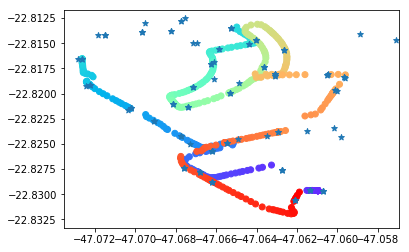

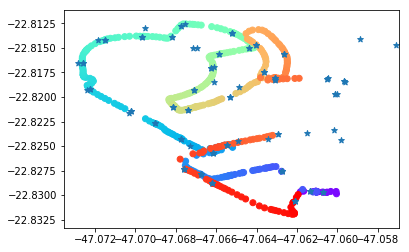

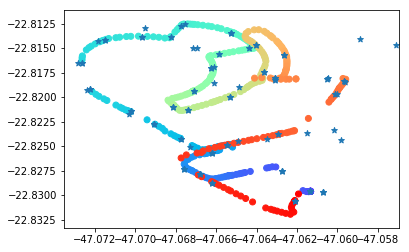

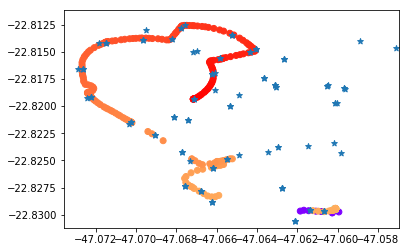

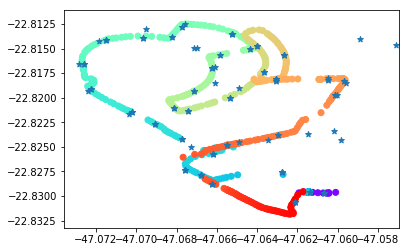

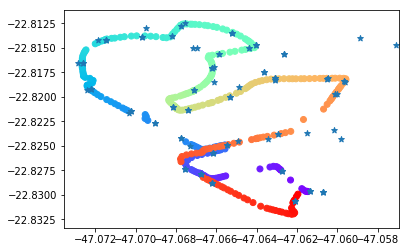

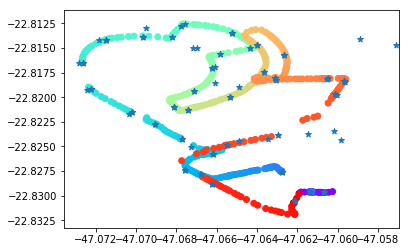

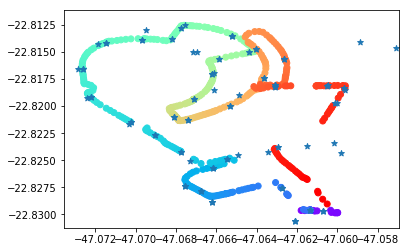

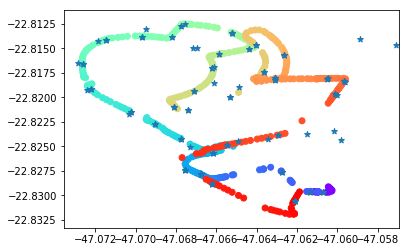

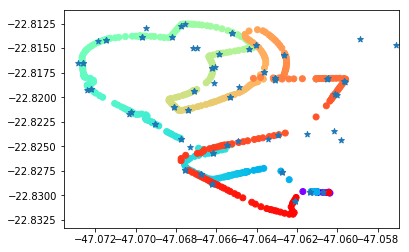

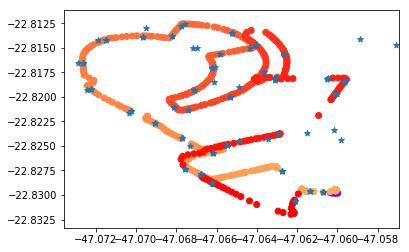

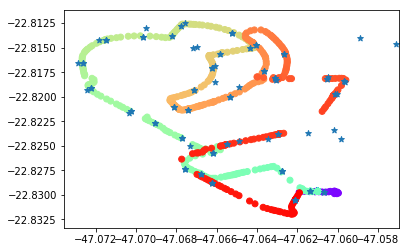

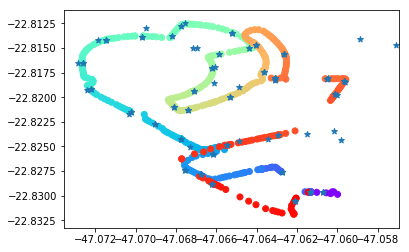

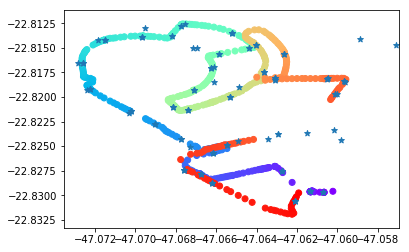

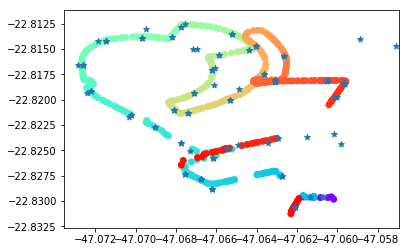

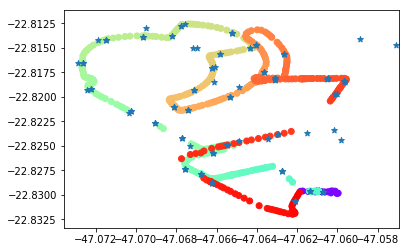

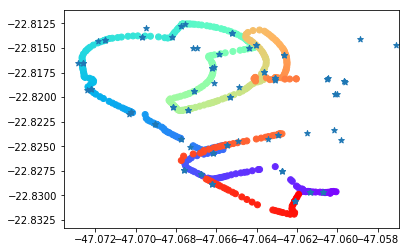

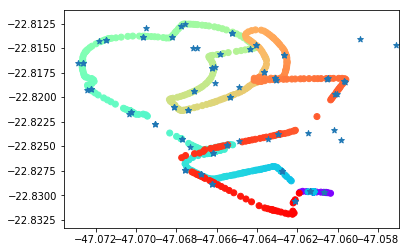

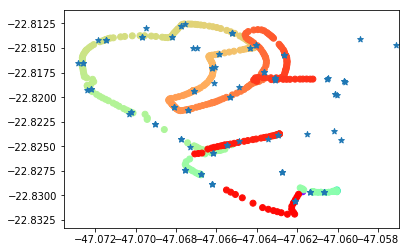

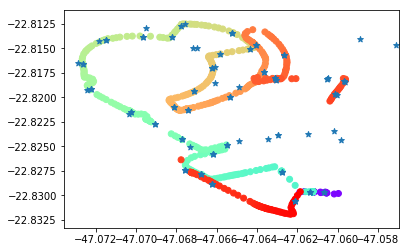

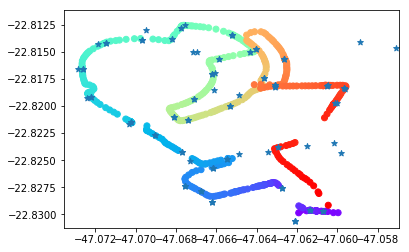

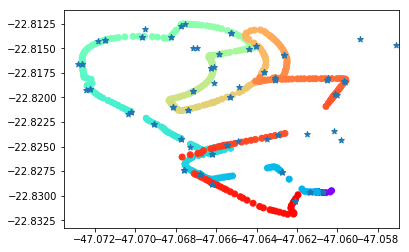

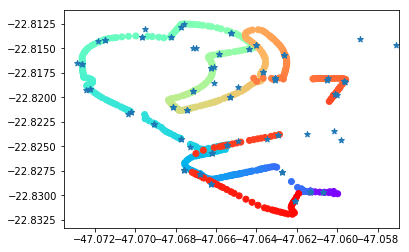

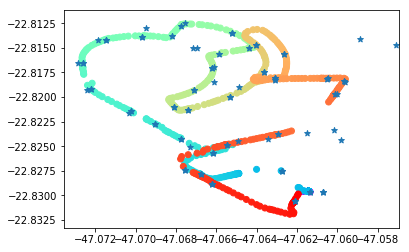

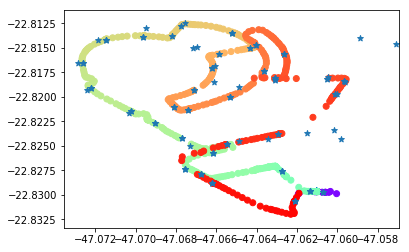

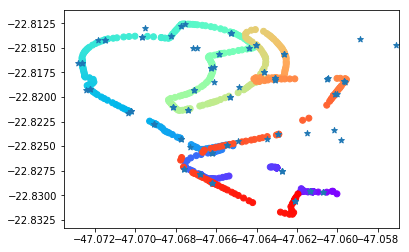

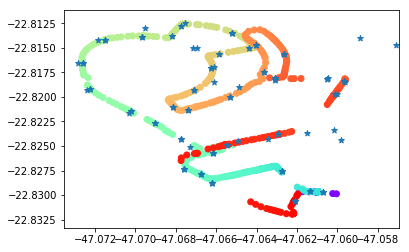

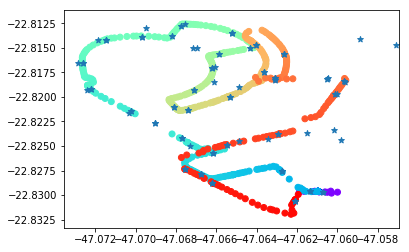

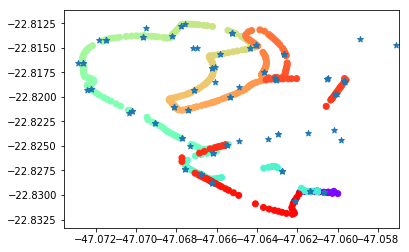

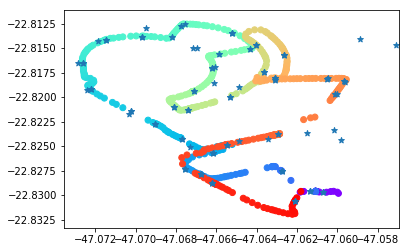

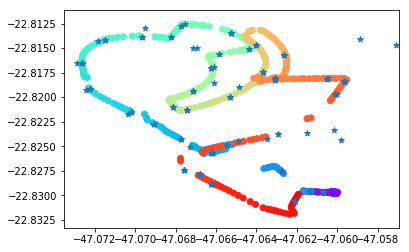

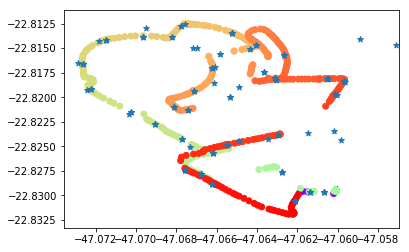

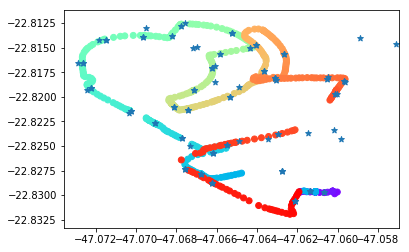

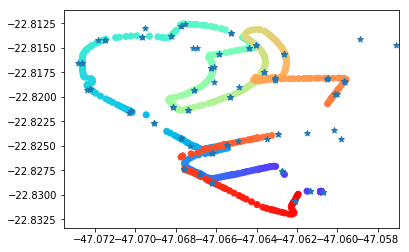

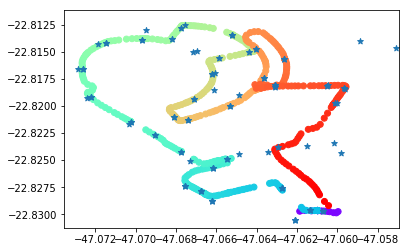

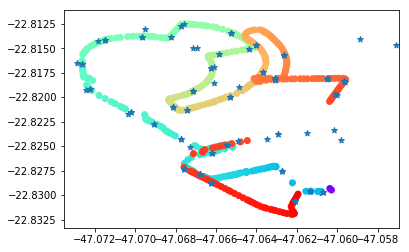

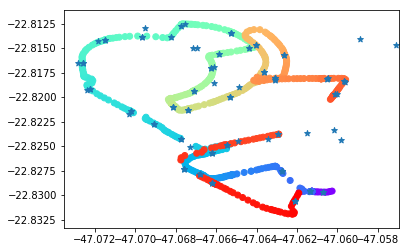

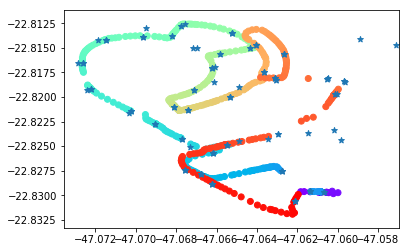

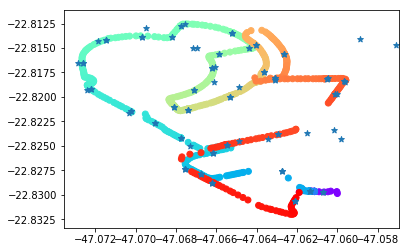

In [70]:
for path_id in range(paths_df['Path Index'].min(), paths_df['Path Index'].max() + 1):
    current_path_df = paths_df[paths_df['Path Index'] == path_id]
    plot_path(current_path_df)

In [0]:
avg_path_df = pd.DataFrame()
for path_id in range(paths_df['Path Index'].min(), paths_df['Path Index'].max() + 1):
    current_path_df = paths_df[paths_df['Path Index'] == path_id]
    avg_path_df = avg_path_df.append(apply_average_time_window(current_path_df))

In [96]:
avg_path_df

,Path Index,id_line,latitude,longitude
0,1.0,2.0,-22.829637,-47.060961
1,1.0,2.0,-22.829637,-47.060960
2,1.0,2.0,-22.829637,-47.060960
3,1.0,2.0,-22.829637,-47.060960
4,1.0,2.0,-22.829637,-47.060960
5,1.0,2.0,-22.829637,-47.060960
6,1.0,2.0,-22.829637,-47.060960
7,1.0,2.0,-22.829637,-47.060960
8,1.0,2.0,-22.829637,-47.060960
9,1.0,2.0,-22.829637,-47.060960


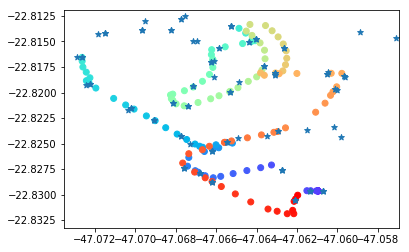

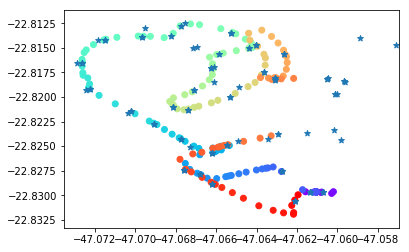

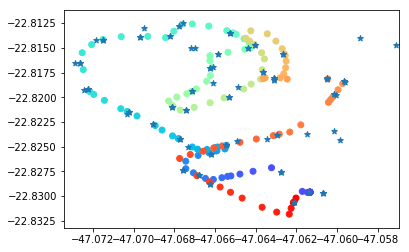

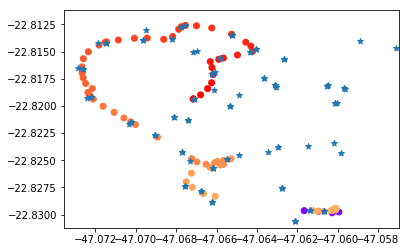

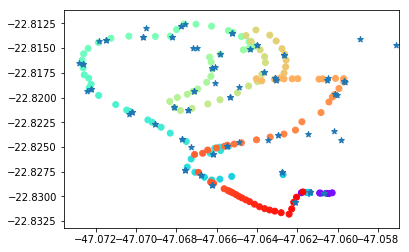

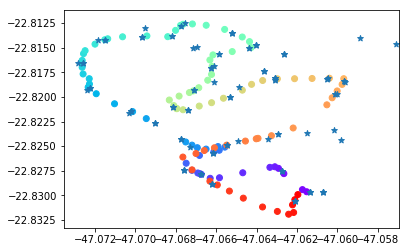

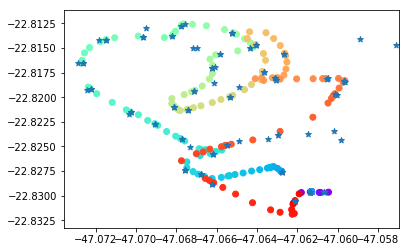

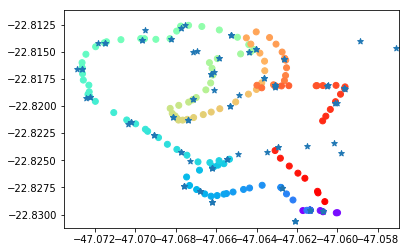

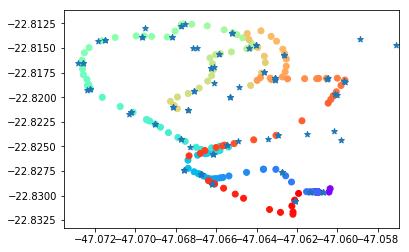

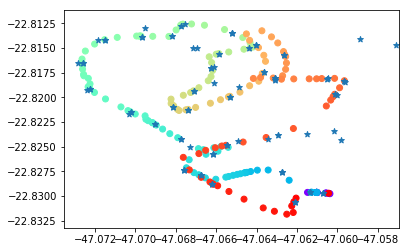

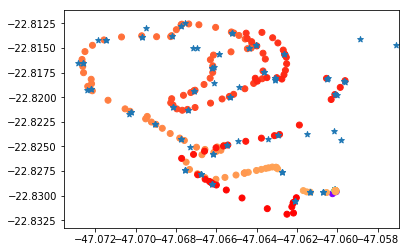

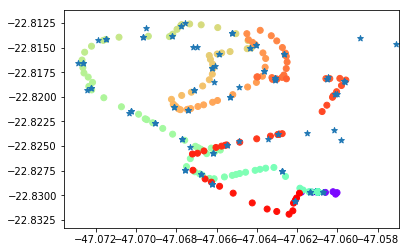

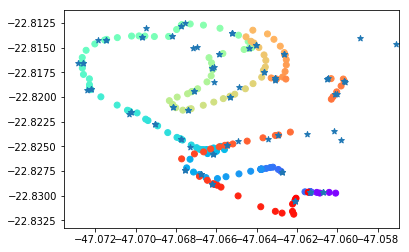

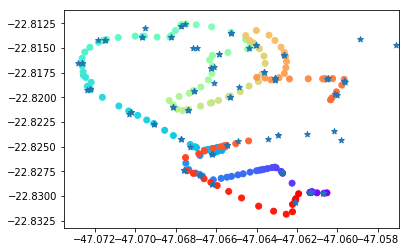

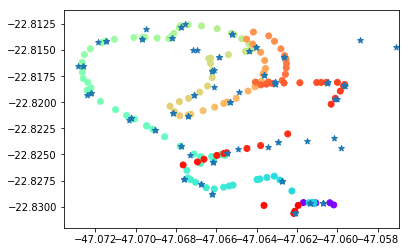

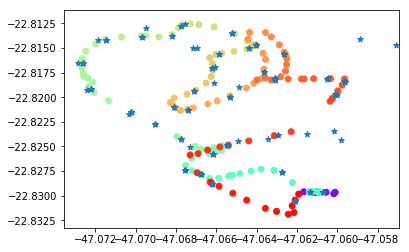

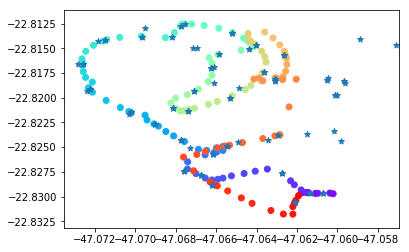

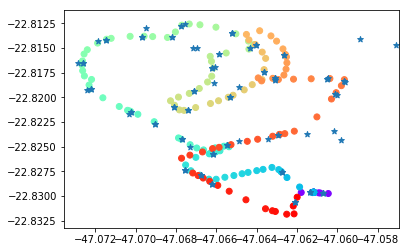

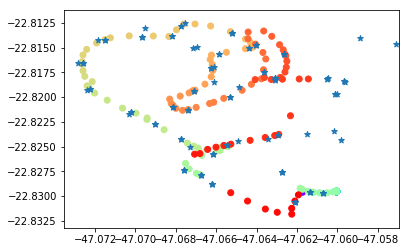

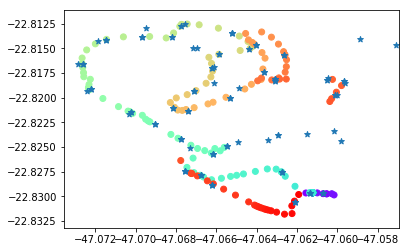

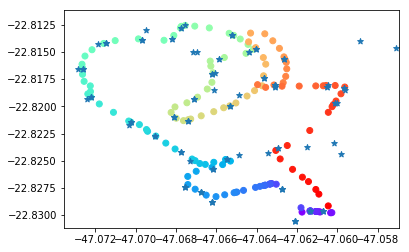

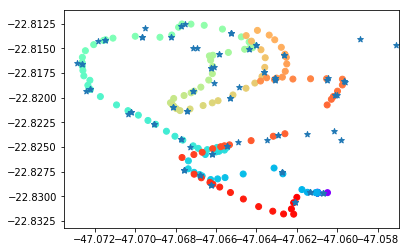

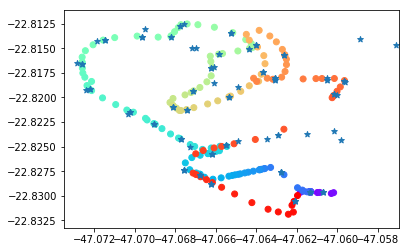

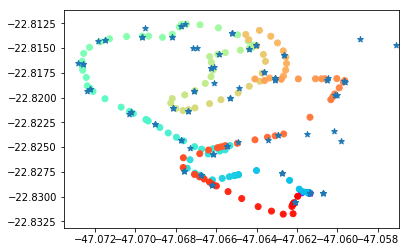

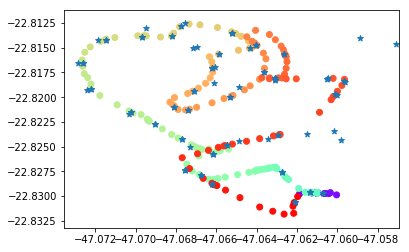

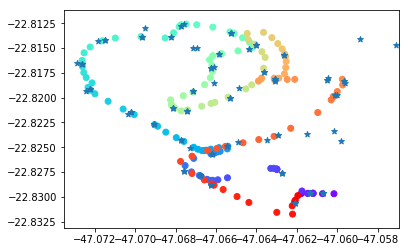

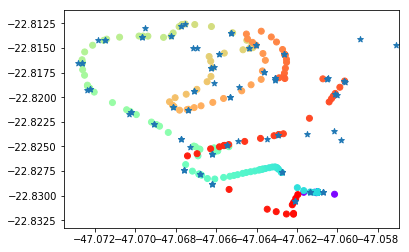

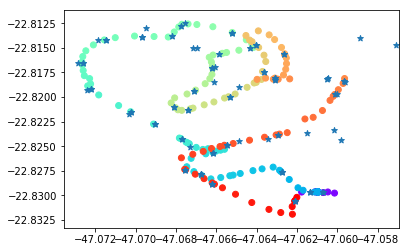

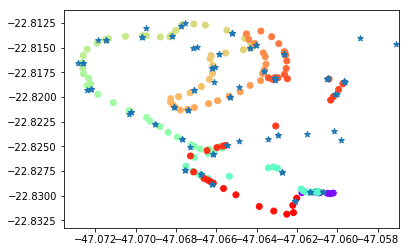

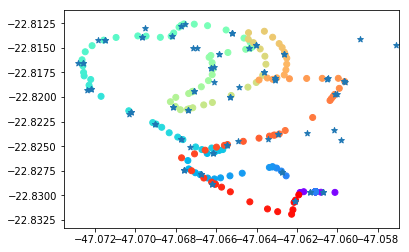

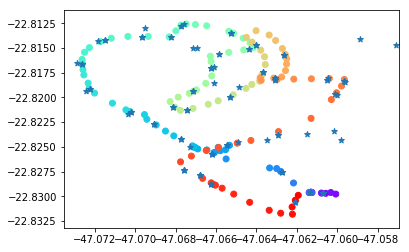

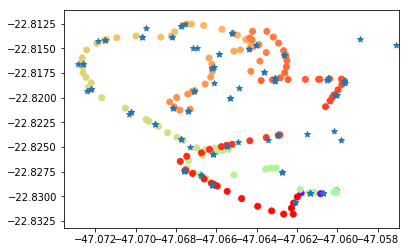

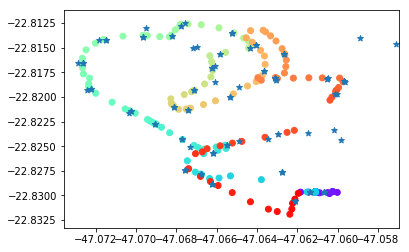

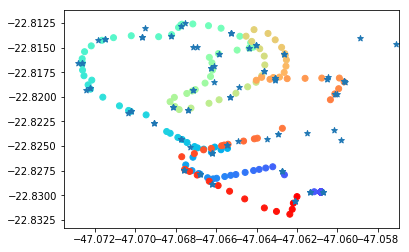

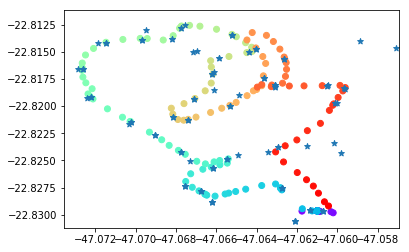

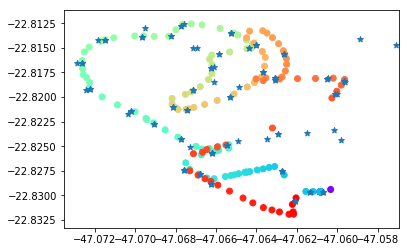

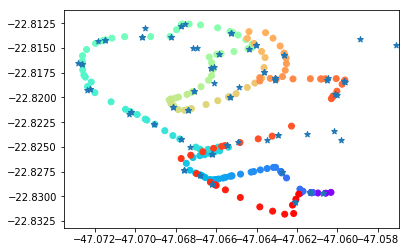

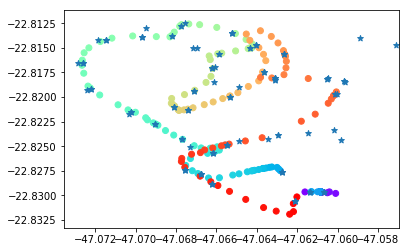

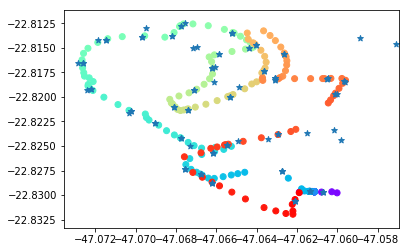

In [98]:
for path_id in range(int(avg_path_df['Path Index'].min()), int(avg_path_df['Path Index'].max()) + 1):
    current_path_df = avg_path_df[avg_path_df['Path Index'] == path_id]
    plot_path(current_path_df)

In [0]:
#for i in range(len(paths_avg)):
#    print('iteration: ' + str(i) + ' - id: ' + str(paths_avg[i][0].id_line))
#    plot_path(paths_avg[i])

In [0]:
paths_avg = []
for path in paths:
    paths_avg.append(apply_average_time_window(path))

In [0]:
#for i in range(len(paths_avg)):
#    print('iteration: ' + str(i) + ' - id: ' + str(paths_avg[i][0].id_line))
#    plot_path(paths_avg[i])

In [0]:
# Use: https://www.mapcustomizer.com/#bulkEntryModal
#for coordinate in paths[385]:
#    print(coordinate.latitude, coordinate.longitude)
#has_distance_greater_from_home(paths[368])
#paths.pop(385)
#pass

In [0]:
# Getting all possible id_linha in paths

#id_lines = {}
#for path in paths:
#    id_line = path[0].id_line
#    if id_line in id_lines:
#        id_lines[id_line] += 1
#    else:
#        id_lines[id_line] = 1
#
#print(id_lines)

In [0]:
#numbers_id = {1:0, 2:0, 3:0, 4:0}
#for path in paths:
#    id_line = path[0].id_line
#    start_time = collect_time(path[0].timestamp)
#    stop_time = collect_time(path[-1].timestamp)
#    
#    numbers_id[id_line] += len(path)/(stop_time - start_time).total_seconds() 
#    
#numbers_id[1] /= id_lines[1]
#numbers_id[2] /= id_lines[2]
#numbers_id[3] /= id_lines[3]
#numbers_id[4] /= id_lines[4]
#
#print(numbers_id)
#      

In [0]:
# Getting all possible device id
#quantity_and_value = {'quantity': 0, 'value': 0}
#numbers_id = {1: quantity_and_value.copy(), 2: quantity_and_value.copy(), 3: quantity_and_value.copy(), 4: quantity_and_value.copy()}
#id_devices = {circulino4: copy.deepcopy(numbers_id), circulino5: copy.deepcopy(numbers_id), circulino6: copy.deepcopy(numbers_id), circulino7: copy.deepcopy(numbers_id), circulino8: copy.deepcopy(numbers_id)}
#for path in paths:
#    id_device = path[0].device_guid
#    id_line = path[0].id_line
#    start_time = collect_time(path[0].timestamp)
#    stop_time = collect_time(path[-1].timestamp)
#    
#    id_devices[id_device][id_line]['value'] += len(path)/(stop_time - start_time).total_seconds() 
#    id_devices[id_device][id_line]['quantity'] += 1
#    
#for id_device in available_circulars:
#    
#    if id_devices[id_device][1]['quantity'] > 0:
#        id_devices[id_device][1]['value'] /= id_devices[id_device][1]['quantity']
#    if id_devices[id_device][2]['quantity'] > 0:
#        id_devices[id_device][2]['value'] /= id_devices[id_device][2]['quantity']
#    if id_devices[id_device][3]['quantity'] > 0:
#        id_devices[id_device][3]['value'] /= id_devices[id_device][3]['quantity']
#    if id_devices[id_device][4]['quantity'] > 0:
#        id_devices[id_device][4]['value'] /= id_devices[id_device][4]['quantity']
#
#print(id_devices)

In [0]:
#X_train, X_test, y_train, y_test = separate_train_test(paths)
#musium_hot_point = Coordinate(-22.814127, -47.058833)
#circular1_hot_point = Coordinate(-22.824493, -47.059594)
#fec_hot_point = Coordinate(-22.817975, -47.059667)
#index = 12
#current_path = all_X = separate_X_paths([paths[index]])[0] 
#
#if has_distance_from_coordinate(current_path, musium_hot_point, 0.3):
#    print(4)
#if has_distance_from_coordinate(current_path, circular1_hot_point, 0.25):
#    print(1)
#if has_distance_from_coordinate(current_path, fec_hot_point, 0.25):
#    print(2)
#
#print(3)
#

In [0]:
#has_distande_from()

In [0]:
predictor = Predictor(DumpAlgorithm())
prediction, y = predict(paths_avg, predictor)

In [0]:

correctness = anilyze_prediction(prediction, y)


In [0]:
plot_correctness(correctness)

In [0]:
predictor = Predictor(BayesAlgorithm())
X_train, X_test, y_train, y_test = separate_train_test(paths_avg)
predictor.train(X_train, y_train)


In [0]:
prediction = predict_X(X_test, predictor)


In [0]:
correctness = anilyze_prediction(prediction, y_test)
plot_correctness(correctness)

In [0]:
maior = 0
for x in X_train + X_test:
    if len(x) > maior:
        maior = len(x)
print(maior)